# Appendix F: Models of uncompensated patch-clamp

Based on the discussion in [Appendix E](./appendix-E-non-ideal-op-amp.ipynb) we now look at models of uncompensated patch clamp, with leak current omitted for simplicity.

<img src="./resources/patch-amp-6-cell-Iin.png" />

We now write an equation for the voltage at every junction, starting bottom left:

\begin{align}
1. && C_m\dot{V}_m = \frac{V_p - V_m}{R_s} - I
\end{align}

where $I$ is the non-capacitative current through the cell membrane.

Next,

\begin{align}
2a. && C_p\dot{V}_p = \frac{V_o-V_p}{R_f} + C_f\left(\dot{V}_o-\dot{V}_p\right) - \frac{V_p-V_m}{R_s}
\end{align}

which can be used as a differential equation for either $V_p$

\begin{align}
(C_p + C_f)\dot{V}_p = \frac{V_o-V_p}{R_f} + C_f\dot{V}_o - \frac{V_p-V_m}{R_s}
\end{align}
or $V_o$
\begin{align}
C_f\dot{V}_o = \frac{V_p-V_o}{R_f} + \left(C_p+C_f\right)\dot{V}_p + \frac{V_p-V_m}{R_s}
\end{align}

Next, we have two options for an op-amp equation:

\begin{align}
3a. && \tau_a\dot{V}_o = V_c - V_p \\
3b. && \tau_c\dot{V}_p = V_c - V_p \\
\end{align}

where $V_c$ is the command voltage.
The value $\tau_c$ is either a constant (80 nanoseconds) or $\tau_c = \tau_aC_t/C_f$.

And finally

\begin{align}
4. && R_f I_\text{out} \equiv V_\text{out} = V_o - V_c
\end{align}

This gives us two models: (1, 2a, 3a, 4) and (1, 2a, 3b, 4).

## Lei-style model

The model used in Lei et al. (2020) also starts from

\begin{align}
1. && C_m\dot{V}_m = \frac{V_p - V_m}{R_s} - I
\end{align}

(equation S2.10) and 

\begin{align}
3b. && \tau_c\dot{V}_p = V_c - V_p \\
\end{align}

(equation S2.12) but then adds the relationship 
\begin{align}
5. && R_fC_f \dot{I}_\text{out} = I + C_m\dot{V}_m + C_p\dot{V}_p - I_\text{out}
\end{align}

(equations S2.8 and S2.5).
This gives us a full model in (1, 3b, 5).

### Relationship to Sigworth-style model

Using equation 4, $R_fI_\text{out} = V_\text{out} = V_o - V_c$, we can rewrite equation 5 as an ODE for $V_o$:

\begin{align}
C_f(\dot{V}_o - \dot{V}_c) &= I + C_m\dot{V}_m + C_p\dot{V}_p - \frac{V_o - V_c}{R_f} \\
    &= \frac{V_p - V_m}{R_s} + C_p\dot{V}_p - \frac{V_o - V_c}{R_f} \\
\end{align}

\begin{align}
2b. && C_f\dot{V}_o = \frac{V_c - V_o}{R_f} + C_p\dot{V}_p + C_f\dot{V}_c + \frac{V_p - V_m}{R_s}
\end{align}

So that we can write the same model as (1, 2b, 3b, 4).

Comparing to 2a
\begin{align}
C_f\dot{V}_o = \frac{V_p-V_o}{R_f} + \left(C_p+C_f\right)\dot{V}_p + \frac{V_p-V_m}{R_s}
\end{align}

we see that the two are equal when $V_c = V_p$ and $\dot{V}_c = \dot{V}_p$.

### We'll stick to the Lei et al. formulation

Equation 2b has a practical downside, in that it has an explicit term $\dot{V}_c$, which is not usually available in simulation software.
To avoid this, we will stick to the (1, 3b, 5) formulation in simulations.

## Three models

From the above, we can distill three models:

- **Model A** - A "Sigworth-style" model (1, 2a, 3a, 4).
- **Model B** - A "Weerakoon" or "Lei-style" model (1, 2b, 3b, 4).
- **Model C** - A hybrid model (1, 2a, 3b, 4).

## Simulations

We now run simulations for a single step from -80 to -20 mV.
The ionic current is set to 0.

We assume that the amplifier was in a steady state before the step, with $V_p$, $V_m$ and $V_c$ all equal to -80 mV.
Since there were no currents, we should get a zero drop over $R_f$, and so $V_o$ was also -80 mV and $I_\text{out}$ was 0.

The values for the different constants are mostly based on Weerakoon et al.
We recalculate $\tau_c$ instead of using the constant value.
The value for $\tau_a$ is the 50ns from Weerakoon et al., slower than the 16ns used in Sigworth 1995.

### Model A: The "Sigworth-style" model

In [1]:
import myokit

import numpy as np
import matplotlib.pyplot as plt

In [2]:
mA = myokit.parse_model('''
[[model]]
cell.Vm = -80
amp.Vp = -80
amp.Vo = -80

[engine]
time = 0 [ms]
    in [ms]
    bind time

[cell]
use amp.Rs, amp.Vp
Cm = 100 [pF]
    in [pF]
I = 0 [pA]
    in [pA]

# Equation 1
dot(Vm) = (Vp - Vm) / (Rs * Cm) - I / Cm
    in [mV]

[amp]
use cell.Vm
Vc = -20 [mV]
    in [mV]
Rs = 0.01 [GOhm]
    in [GOhm]
Rf = 0.025 [GOhm]
    in [GOhm]
Cf = 0.3 [pF]
    in [pF]
Cp = 4.5 [pF]  # Value chosen to get tau_c = 0.8 as in Weerakoon
    in [pF]
Ct = Cf + Cp
    in [pF]
tau_amp = 0.05e-3 [ms]
    in [ms]

# Equation 2a
dot(Vp) = (Vo - Vp) / (Rf * Ct) + Cf / Ct * dot(Vo) - (Vp - Vm) / (Rs * Ct)
    in [mV]

# Equation 3a
dot(Vo) = (Vc - Vp) / tau_amp
    in [mV]

# Equation 4
I_out = (Vo - Vc) / Rf
    in [pA]

''')
mA.check_units(myokit.UNIT_STRICT)

In [3]:
tol = 1e-8
dt = 5e-5

sA = myokit.Simulation(mA)
sA.set_tolerance(tol, tol)
dA = sA.run(10, log_interval=dt)

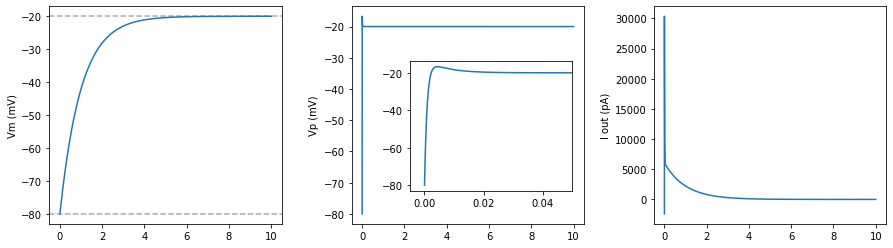

In [4]:
kw = dict(color='#aaa', ls='--')

fig = plt.figure(figsize=(15, 4))
fig.subplots_adjust(wspace=0.3)

ax = fig.add_subplot(1, 3, 1)
ax.set_ylabel('Vm (mV)')
ax.axhline(mA.get('cell.Vm').initial_value().eval(), **kw)
ax.axhline(mA.get('amp.Vc').eval(), **kw)
ax.plot(dA.time(), dA['cell.Vm'])

ax = fig.add_subplot(1, 3, 2)
ax.set_ylabel('Vp (mV)')
ax.plot(dA.time(), dA['amp.Vp'])
ax = ax.inset_axes((0.25, 0.15, 0.7, 0.6))
ax.plot(dA.time(), dA['amp.Vp'])
ax.set_xlim(-0.005, 0.05)

ax = fig.add_subplot(1, 3, 3)
ax.set_ylabel('I out (pA)')
ax.plot(dA.time(), dA['amp.I_out'])

plt.show()

### Model B: The Weerakoon / Lei formulation

In [5]:
mB = myokit.parse_model('''
[[model]]
cell.Vm = -80
amp.Vp = -80
amp.I_out = 0

[engine]
time = 0 [ms]
    in [ms]
    bind time

[cell]
use amp.Rs, amp.Vp
Cm = 100 [pF]
    in [pF]
I = 0 [pA]
    in [pA]

# Equation 1 (S2.10)
dot(Vm) = (Vp - Vm) / (Rs * Cm) - I / Cm
    in [mV]

[amp]
use cell.Vm, cell.Cm, cell.I
Vc = -20 [mV]
    in [mV]
Rs = 0.01 [GOhm]
    in [GOhm]
Rf = 0.025 [GOhm]
    in [GOhm]
Cf = 0.3 [pF]
    in [pF]
Cp = 4.5 [pF]
    in [pF]
tau_amp = 0.05e-3 [ms]
    in [ms]
tau_c = tau_amp * (Cf + Cp) / Cf
    in [ms]

# Equation 3b (S2.12)
dot(Vp) = (Vc - Vp) / tau_c
    in [mV]

# Equation 5 (S2.5 and S2.8)
dot(I_out) = (I + Cm * dot(Vm) + Cp * dot(Vp) - I_out) / (Rf * Cf)
    in [pA]
''')
mB.check_units(myokit.UNIT_STRICT)

In [6]:
# Check that we set the tau values for tau_c = 0.8 us
print(f'Tau c: {mB.get("amp.tau_c").eval() * 1e3} us')

Tau c: 0.8 us


In [7]:
sB = myokit.Simulation(mB)
sB.set_tolerance(tol, tol)
dB = sB.run(10, log_interval=dt)

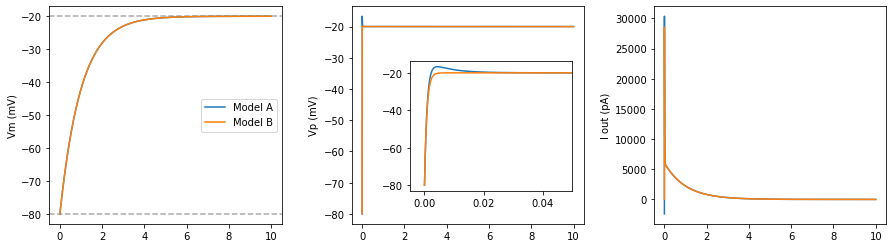

In [8]:
fig = plt.figure(figsize=(15, 4))
fig.subplots_adjust(wspace=0.3)

ax = fig.add_subplot(1, 3, 1)
ax.set_ylabel('Vm (mV)')
ax.axhline(mA.get('cell.Vm').initial_value().eval(), **kw)
ax.axhline(mA.get('amp.Vc').eval(), **kw)
ax.plot(dA.time(), dA['cell.Vm'], label='Model A')
ax.plot(dB.time(), dB['cell.Vm'], label='Model B')
ax.legend()

ax = fig.add_subplot(1, 3, 2)
ax.set_ylabel('Vp (mV)')
ax.plot(dA.time(), dA['amp.Vp'], label='Model A')
ax.plot(dB.time(), dB['amp.Vp'], label='Model B')
ax = ax.inset_axes((0.25, 0.15, 0.7, 0.6))
ax.plot(dA.time(), dA['amp.Vp'], label='Model A')
ax.plot(dB.time(), dB['amp.Vp'], label='Model B')
ax.set_xlim(-0.005, 0.05)

ax = fig.add_subplot(1, 3, 3)
ax.set_ylabel('I out (pA)')
ax.plot(dA.time(), dA['amp.I_out'], label='Model A')
ax.plot(dB.time(), dB['amp.I_out'], label='Model B')
plt.show()

We can see two differences here:

- The pipette voltage $V_p$ overshoots in Model A, but not Model B
- Because of how we chose the initial conditions, $I_\text{out}$ is non-zero at the first simulation point.

### Model C: The hybrid model

To see whether the difference is due to 2a vs 2b or 3a vs 3b, we can look at the hybrid model C.

In [9]:
mC = myokit.parse_model('''
[[model]]
cell.Vm = -80
amp.Vp = -80
amp.Vo = -80

[engine]
time = 0 [ms]
    in [ms]
    bind time

[cell]
use amp.Rs, amp.Vp
Cm = 100 [pF]
    in [pF]
I = 0 [pA]
    in [pA]

# Equation 1
dot(Vm) = (Vp - Vm) / (Rs * Cm) - I / Cm
    in [mV]

[amp]
use cell.Vm
Vc = -20 [mV]
    in [mV]
Rs = 0.01 [GOhm]
    in [GOhm]
Rf = 0.025 [GOhm]
    in [GOhm]
Cf = 0.3 [pF]
    in [pF]
Cp = 4.5 [pF]
    in [pF]
tau_amp = 0.05e-3 [ms]
    in [ms]
tau_c = tau_amp * (Cf + Cp) / Cf
    in [ms]

# Equation 2a, Vo version
dot(Vo) = (Vp - Vo) / (Rf * Cf) + (Cp + Cf) / Cf * dot(Vp) + (Vp - Vm) / (Rs * Cf)
    in [mV]

# Equation 3b
dot(Vp) = (Vc - Vp) / tau_c
    in [mV]

# Equation 4
I_out = (Vo - Vc) / Rf
    in [pA]

''')
mC.check_units(myokit.UNIT_STRICT)

In [10]:
sC = myokit.Simulation(mC)
sC.set_tolerance(tol, tol)
dC = sC.run(10, log_interval=dt)

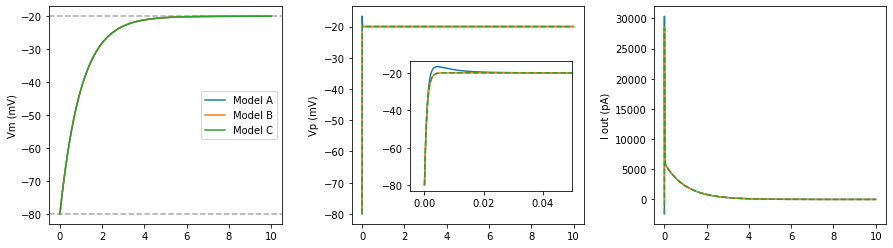

In [11]:
fig = plt.figure(figsize=(15, 4))
fig.subplots_adjust(wspace=0.3)

ax = fig.add_subplot(1, 3, 1)
ax.set_ylabel('Vm (mV)')
ax.axhline(mA.get('cell.Vm').initial_value().eval(), **kw)
ax.axhline(mA.get('amp.Vc').eval(), **kw)
ax.plot(dA.time(), dA['cell.Vm'], label='Model A')
ax.plot(dB.time(), dB['cell.Vm'], label='Model B')
ax.plot(dC.time(), dC['cell.Vm'], label='Model C')
ax.legend()

ax = fig.add_subplot(1, 3, 2)
ax.set_ylabel('Vp (mV)')
ax.plot(dA.time(), dA['amp.Vp'], label='Model A')
ax.plot(dB.time(), dB['amp.Vp'], label='Model B')
ax.plot(dC.time(), dC['amp.Vp'], '--', label='Model C')
ax = ax.inset_axes((0.25, 0.15, 0.7, 0.6))
ax.plot(dA.time(), dA['amp.Vp'], label='Model A')
ax.plot(dB.time(), dB['amp.Vp'], label='Model B')
ax.plot(dC.time(), dC['amp.Vp'], '--', label='Model C')
ax.set_xlim(-0.005, 0.05)

ax = fig.add_subplot(1, 3, 3)
ax.set_ylabel('I out (pA)')
ax.plot(dA.time(), dA['amp.I_out'], label='Model A')
ax.plot(dB.time(), dB['amp.I_out'], label='Model B')
ax.plot(dC.time(), dC['amp.I_out'], '--', label='Model C')
plt.show()

### Cross-comparison

We can get a closer look at the differences by plotting them explicitly.
For $V_p$ and $I_\text{out}$ we'll zoom in on the first few $\mu$s.

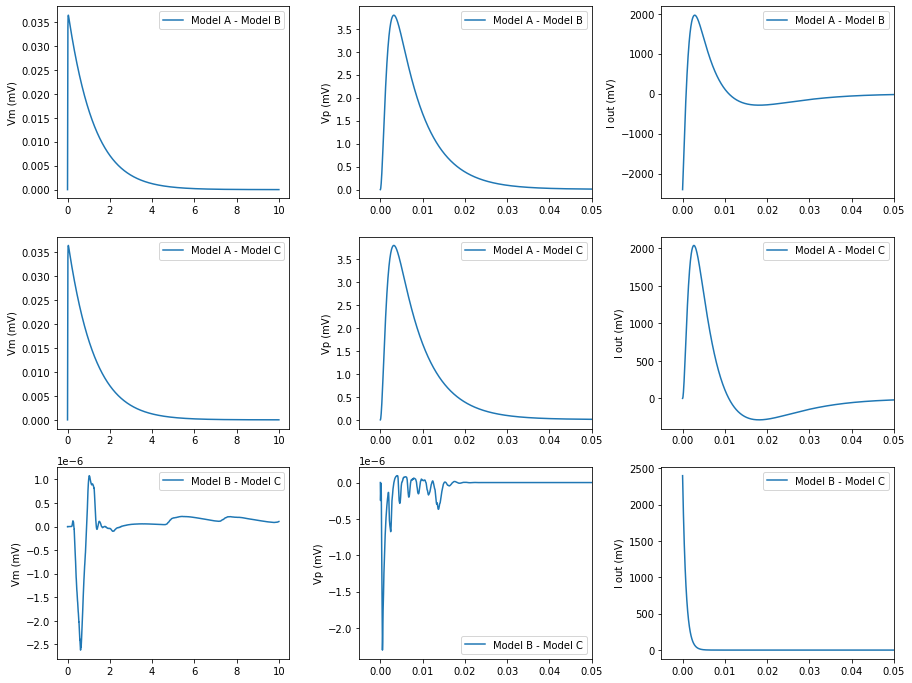

In [12]:
dA = dA.npview()
dB = dB.npview()
dC = dC.npview()
xlim = -0.005, 0.05

fig = plt.figure(figsize=(15, 12))
fig.subplots_adjust(wspace=0.3)

ax = fig.add_subplot(3, 3, 1); ax.set_ylabel('Vm (mV)')
ax.plot(dA.time(), dA['cell.Vm'] - dB['cell.Vm'], label='Model A - Model B'); ax.legend()
ax = fig.add_subplot(3, 3, 4); ax.set_ylabel('Vm (mV)')
ax.plot(dA.time(), dA['cell.Vm'] - dC['cell.Vm'], label='Model A - Model C'); ax.legend()
ax = fig.add_subplot(3, 3, 7); ax.set_ylabel('Vm (mV)')
ax.plot(dB.time(), dB['cell.Vm'] - dC['cell.Vm'], label='Model B - Model C'); ax.legend()

ax = fig.add_subplot(3, 3, 2); ax.set_ylabel('Vp (mV)')
ax.plot(dA.time(), dA['amp.Vp'] - dB['amp.Vp'], label='Model A - Model B'); ax.legend(); ax.set_xlim(*xlim)
ax = fig.add_subplot(3, 3, 5); ax.set_ylabel('Vp (mV)')
ax.plot(dA.time(), dA['amp.Vp'] - dC['amp.Vp'], label='Model A - Model C'); ax.legend(); ax.set_xlim(*xlim)
ax = fig.add_subplot(3, 3, 8); ax.set_ylabel('Vp (mV)')
ax.plot(dB.time(), dB['amp.Vp'] - dC['amp.Vp'], label='Model B - Model C'); ax.legend(); ax.set_xlim(*xlim)

ax = fig.add_subplot(3, 3, 3); ax.set_ylabel('I out (mV)')
ax.plot(dA.time(), dA['amp.I_out'] - dB['amp.I_out'], label='Model A - Model B'); ax.legend(); ax.set_xlim(*xlim)
ax = fig.add_subplot(3, 3, 6); ax.set_ylabel('I out (mV)')
ax.plot(dA.time(), dA['amp.I_out'] - dC['amp.I_out'], label='Model A - Model C'); ax.legend(); ax.set_xlim(*xlim)
ax = fig.add_subplot(3, 3, 9); ax.set_ylabel('I out (mV)')
ax.plot(dB.time(), dB['amp.I_out'] - dC['amp.I_out'], label='Model B - Model C'); ax.legend(); ax.set_xlim(*xlim)

plt.show()

Here, we see

- A minor difference in $V_m$ between Model A and Models B & C, which is only visible when plotting the difference explicitly.
- Some differences between Model A and Models B & C in the early $\mu$s of $V_p$ and $I_\text{out}$.
- Differences between Model B and Model C in $V_m$ and $V_p$ look to be due to numerical noise. The main difference between these two models is in the early $\mu$s of $I_\text{out}$.

## Models A and B with a high parasitic capcitance

For Model A, we can calculate the damping factor as

\begin{align}
\zeta = \frac{\tau_a + R_fC_f}{\sqrt{\tau_a R_f (C_p+C_f)}}
\end{align}

In [13]:
Rf = 0.025 # GOhm
Cf = 0.3 # pF
Cp = 4.5 # pF, pF * GOhm = ms
tau_amp = 0.05e-3 # ms

zeta = (tau_amp + Rf*Cf) / np.sqrt(tau_amp * Rf * (Cf + Cp))
# (ms + ms) / sqrt(ms * ms) = dimensionless

print(f'Zeta: {zeta}')

Zeta: 3.082274593002165


Since $\tau_a$, $R_f$, and $C_f$ are set by the amplifier designer, the only experimental variation we can expect here is in $C_p$.
If, for whatever reason, we have an unusually large $C_p$, this can lead the damping factor to drop below 1, so that ringing can occur:

In [14]:
Cp *= 20
zeta = (tau_amp + Rf*Cf) / np.sqrt(tau_amp * Rf * (Cf + Cp))
print(f'Zeta: {zeta}')

Zeta: 0.7106374160558676


In [15]:
new_Cp = 4.5 * 20
sA.set_constant('amp.Cp', new_Cp)
sB.set_constant('amp.Cp', new_Cp)
sA.reset()
sB.reset()
dA = sA.run(10)
dB = sB.run(10)

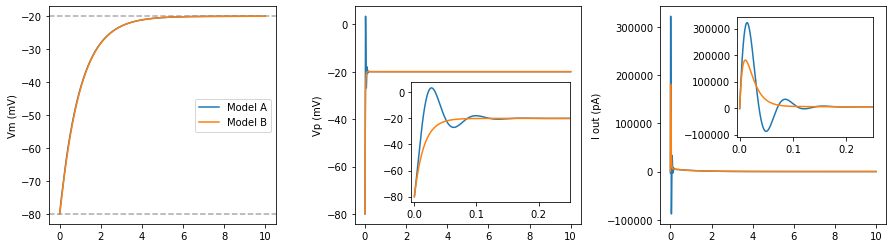

In [16]:
fig = plt.figure(figsize=(15, 4))
fig.subplots_adjust(wspace=0.35)

ax = fig.add_subplot(1, 3, 1)
ax.set_ylabel('Vm (mV)')
ax.axhline(mA.get('cell.Vm').initial_value().eval(), **kw)
ax.axhline(mA.get('amp.Vc').eval(), **kw)
ax.plot(dA.time(), dA['cell.Vm'], label='Model A')
ax.plot(dB.time(), dB['cell.Vm'], label='Model B')
ax.legend()

ax = fig.add_subplot(1, 3, 2)
ax.set_ylabel('Vp (mV)')
ax.plot(dA.time(), dA['amp.Vp'])
ax.plot(dB.time(), dB['amp.Vp'])
ax = ax.inset_axes((0.25, 0.10, 0.7, 0.55))
ax.plot(dA.time(), dA['amp.Vp'])
ax.plot(dB.time(), dB['amp.Vp'])
ax.set_xlim(-0.005, 0.25)

ax = fig.add_subplot(1, 3, 3)
ax.set_ylabel('I out (pA)')
ax.plot(dA.time(), dA['amp.I_out'])
ax.plot(dB.time(), dB['amp.I_out'])
ax = ax.inset_axes((0.34, 0.40, 0.6, 0.55))
ax.plot(dA.time(), dA['amp.I_out'])
ax.plot(dB.time(), dB['amp.I_out'])
ax.set_xlim(-0.005, 0.25)

plt.show()

Here we see the expected ringing behaviour in Model A, while the simplified equations in Model B show a simpler response.

## Conclusions

- Model A, which uses the op-amp equation from Sigworth 1995a, exhibits more complicated dynamics than Model B, which is based on a dominant-pole approximation of Model A.
- However, the differences in $V_m$ are neglible, while differences in $V_p$ and $I_\text{out}$ occur only in the first $\mu$s under normal circumstances.
- When $C_p$ is made large, the difference between the models becomes more notable, and Model A can exhibit ringing. However, this lasts for less than a ms.
- If we assume an ideal op-amp, so that $V_p = V_c$ (and $\dot{V}_p = \dot{V}_c$), then Model B equals Model A.